In [204]:
%env THEANO_FLAGS="divice=gpu5"
import numpy as np
import pandas as pd

import theano
import seaborn as sns
sns.set_style('white')
import theano.tensor as T

import scipy.io.wavfile as wav
import pickle
import random

from numpy import linalg as la, random as rnd

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import lasagne


from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

env: THEANO_FLAGS="divice=gpu5"


In [2]:
def retrieve_preprocessed_data(fname='valid_data'):
    data_from_file = np.load('{}.npz'.format(fname))
    data_table = pd.read_csv('{}.csv'.format(fname))
    data_dict = np.asscalar(data_from_file['arr_0'])
    return data_table, data_dict['timesequences'], data_dict['spectrograms']

In [3]:
valid_data, valid_timesequences, valid_spectrograms = retrieve_preprocessed_data('valid_data')

In [4]:
valid_data.shape, valid_timesequences.shape, valid_spectrograms.shape

((4088, 5), (4088, 11025), (4088, 128, 22))

In [5]:
valid_spectrograms = valid_spectrograms.astype('float32')

In [6]:
valid_data = valid_data.drop(['Unnamed: 0'], axis=1)

In [7]:
valid_data.head()

,words,authors,links,matrix_index
0,Бенилюкс,ivga,http://ru.forvo.com/word/%D0%B1%D0%B5%D0%BD%D0...,0
1,большая гармония гласных,rutre15,http://ru.forvo.com/word/%D0%B1%D0%BE%D0%BB%D1...,1
2,малая гармония гласных,rutre15,http://ru.forvo.com/word/%D0%BC%D0%B0%D0%BB%D0...,2
3,бумажный стаканчик,Patient228,http://ru.forvo.com/word/%D0%B1%D1%83%D0%BC%D0...,3
4,бумажный стаканчик,rutre15,http://ru.forvo.com/word/%D0%B1%D1%83%D0%BC%D0...,4


# Data

In [8]:
import pickle
answer = pickle.load(open('dataset/ajnsdjasnd.pcl','rb'))

In [9]:
data = pd.DataFrame.from_csv('data.csv')

In [10]:
data.head()

,words,authors,links
0,Бенилюкс,ivga,http://ru.forvo.com/word/%D0%B1%D0%B5%D0%BD%D0...
1,большая гармония гласных,rutre15,http://ru.forvo.com/word/%D0%B1%D0%BE%D0%BB%D1...
2,малая гармония гласных,rutre15,http://ru.forvo.com/word/%D0%BC%D0%B0%D0%BB%D0...
3,бумажный стаканчик,Patient228,http://ru.forvo.com/word/%D0%B1%D1%83%D0%BC%D0...
4,бумажный стаканчик,rutre15,http://ru.forvo.com/word/%D0%B1%D1%83%D0%BC%D0...


In [11]:
answer_T = {v: k for k, v in answer.items()}

In [12]:
from sklearn.cross_validation import train_test_split

In [13]:
dtrain, dtest, tstrain, tstest, sptrain, sptest = train_test_split(valid_data, valid_timesequences, valid_spectrograms)

In [14]:
[len(a) for a in [dtrain, dtest, tstrain, tstest, sptrain, sptest]]

[3066, 1022, 3066, 1022, 3066, 1022]

# Neuronet

In [231]:
input_X = T.tensor4("X", dtype='float32')

In [237]:
#
#
#    FIRST INPUT
#
#



input_layer = lasagne.layers.InputLayer(shape = (None, None, 22, 128), input_var=input_X.swapaxes(2,3))

nn = lasagne.layers.ReshapeLayer(input_layer, (-1, 22, 128))

# ---

nn = lasagne.layers.Conv1DLayer(nn, num_filters = 16, filter_size = 3,
                                    nonlinearity= lasagne.nonlinearities.very_leaky_rectify)
nn = lasagne.layers.MaxPool1DLayer(nn, 2)

# ---

nn = lasagne.layers.GlobalPoolLayer(nn)

# ---

nn = lasagne.layers.DenseLayer(nn, num_units = 64, nonlinearity=lasagne.nonlinearities.very_leaky_rectify)

n = 16

nn = lasagne.layers.DenseLayer(nn, num_units = n, nonlinearity=lasagne.nonlinearities.identity,
                                        name='output')

dense_output = lasagne.layers.ReshapeLayer(nn, (-1, 3, n)) # for loss

dense_out = lasagne.layers.ReshapeLayer(nn, (-1, 2, n)) # for use

In [241]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output) # for loss

y_pred = lasagne.layers.get_output(dense_out) # for use

#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output,trainable=True)

#функция ошибки
loss = (T.maximum(T.sum(T.sqr(y_predicted[:, 0] - y_predicted[:, 2])) + 1e-2, 0)
        - T.maximum(T.sum(T.sqr(y_predicted[:, 0] - y_predicted[:, 1])) + 1e-2, 0))

def th_vec_len(v):
    return T.sqrt(T.sum(T.sqr(v + 1e-5)))

def th_cos_distance(v1, v2):
    return T.dot(v1, v2) / (th_vec_len(v1) * th_vec_len(v2))

#loss = (T.maximum(th_cos_distance(y_predicted[:, 0], y_predicted[:, 1]) + 1e-2, 0)
#            - T.maximum(th_cos_distance(y_predicted[:, 0], y_predicted[:, 2]) + 1e-2, 0))

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adam(loss,all_weights,learning_rate = 0.01)

#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X],[loss],updates= updates_sgd)

#функция, которая считает точность
predict = theano.function([input_X], y_pred)

# Data

In [245]:
valid_spectrograms /= np.max(np.abs(valid_spectrograms))

In [243]:
print(len(valid_data))
valid_data.head()

4088


,words,authors,links,matrix_index
0,Бенилюкс,ivga,http://ru.forvo.com/word/%D0%B1%D0%B5%D0%BD%D0...,0
1,большая гармония гласных,rutre15,http://ru.forvo.com/word/%D0%B1%D0%BE%D0%BB%D1...,1
2,малая гармония гласных,rutre15,http://ru.forvo.com/word/%D0%BC%D0%B0%D0%BB%D0...,2
3,бумажный стаканчик,Patient228,http://ru.forvo.com/word/%D0%B1%D1%83%D0%BC%D0...,3
4,бумажный стаканчик,rutre15,http://ru.forvo.com/word/%D0%B1%D1%83%D0%BC%D0...,4


In [246]:
index_pool = set(valid_data['matrix_index'])

In [247]:
author_index_pool = {author: set(valid_data[valid_data['authors'] == author]['matrix_index']) \
                     for author in valid_data['authors'].unique()}

In [248]:
pp = np.array([len(v) for v in list(author_index_pool.values())])

In [249]:
def train_test_authors(valid_data, prob2train=0.5):
    index_pool = set(valid_data['matrix_index'])
    author_index_pool = {author: set(valid_data[valid_data['authors'] == author]['matrix_index']) \
                     for author in valid_data['authors'].unique()}
    train_authors = {author for author in author_index_pool if len(author_index_pool[author]) >= 3}
    #test_authors = {author for author in author_index_pool if len(author_index_pool[author]) == 1}
    test_authors = set()
    neutral_authors = {author for author in author_index_pool if len(author_index_pool[author]) == 2}
    go2train_authors = set(np.random.choice(list(neutral_authors), int(prob2train * len(neutral_authors))))
    train_authors = train_authors.union(go2train_authors)
    test_authors = test_authors.union(neutral_authors - go2train_authors)
    print('is train disjoint with test? {}'.format(train_authors.isdisjoint(test_authors)))
    return train_authors, test_authors

In [250]:
train_authors, test_authors = train_test_authors(valid_data)

is train disjoint with test? True


In [251]:
train_author_index_pool = {k:v for (k, v) in author_index_pool.items() if k in train_authors}
test_author_index_pool = {k:v for (k, v) in author_index_pool.items() if k in test_authors}

In [252]:
train_index_pool = set()
for author_index in train_author_index_pool.values():
    train_index_pool = train_index_pool.union(author_index)

In [253]:
test_index_pool = set()
for author_index in test_author_index_pool.values():
    test_index_pool = test_index_pool.union(author_index)

#test_index_pool = index_pool - train_index_pool

In [254]:
def generate_train_batch(spectrograms,
                         train_author_index_pool,
                         train_index_pool,
                         batch_size):
    batch_authors = np.random.choice(list(train_author_index_pool.keys()), batch_size, replace=True)
    first_indices = []
    second_indices = []
    third_indices = []
    for author in batch_authors:
        author_pool = train_author_index_pool[author]
        first_index = np.random.choice(list(author_pool), 1)[0]
        second_index = np.random.choice(list(author_pool - {first_index}), 1)[0]
        third_index = np.random.choice(list(train_index_pool - author_pool), 1)[0]
    return np.stack([spectrograms[first_index], spectrograms[second_index], spectrograms[third_index]], axis=0)

def generate_test_indices(spectrograms,
                         test_author_index_pool,
                         test_index_pool,
                         only_similar=True):
    first_indices = []
    second_indices = []
    similar = []
    for author in test_author_index_pool.keys():
        for first_index in test_author_index_pool[author]:
            for second_index in (test_author_index_pool[author] - {first_index}):
                # process all similar samples
                first_indices.append(first_index)
                second_indices.append(second_index)
                similar.append(True)
            if not only_similar:
                for second_index in (test_index_pool - test_author_index_pool[author]):
                    # process all distinct samples
                    first_indices.append(first_index)
                    second_indices.append(second_index)
                    similar.append(False)                
    return np.array(first_indices, dtype='int'), np.array(second_indices, dtype='int'), np.array(similar, dtype='bool')

In [255]:
f, s, sm = generate_test_indices(valid_spectrograms, test_author_index_pool, test_index_pool, only_similar=True)

In [256]:
f.size

144

In [257]:
np.average(sm)

1.0

In [258]:
validate_predictions = [predict(np.stack([valid_spectrograms[f], valid_spectrograms[s]], axis=0))]

In [ ]:
www = generate_train_batch(valid_spectrograms,
                                           train_author_index_pool,
                                           train_index_pool,
                                           batch_size=len(train_authors))

In [259]:
batch_size=200
niters=100
nepochs = 10
for epoch in range(nepochs):
    print('Epoch :{}'.format(epoch), flush=True)
    for i in range(niters):
        train_input = generate_train_batch(valid_spectrograms,
                                           train_author_index_pool,
                                           train_index_pool,
                                           batch_size=len(train_authors))
    f, s, sm = generate_test_indices(valid_spectrograms, test_author_index_pool, test_index_pool)
    validate_predictions.append(predict(np.stack([valid_spectrograms[f], valid_spectrograms[s]], axis=0)))

Epoch :0
Epoch :1
Epoch :2
Epoch :3
Epoch :4
Epoch :5
Epoch :6
Epoch :7
Epoch :8
Epoch :9


In [191]:
val_size = validate_predictions[0].shape[0]
print(validate_predictions[2].shape)

(148, 2, 16)


In [192]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / ((la.norm(v1)**2 + 1e-5) * (la.norm(v2)**2 + 1e-5))

In [193]:
def all_cosine_similarity(vec1, vec2):
    return np.stack([cosine_similarity(v1, v2) for (v1, v2) in zip(vec1, vec2)], axis=0)

def epoch_cosine_similarity(epoch_vecs):
    acs_history = []
    for vecs in epoch_vecs:
        acs_history.append(all_cosine_similarity(vecs[:, 0, :], vecs[:, 1, :]))
    return np.stack(acs_history, axis=0)

In [194]:
acs = epoch_cosine_similarity(validate_predictions)

In [195]:
acs.shape

(121, 148)

/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


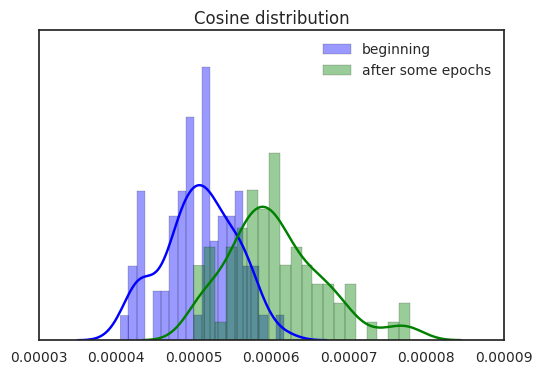

In [236]:
sns.distplot(acs[0].ravel(), bins=20, norm_hist=True, color='b', label='beginning')
sns.distplot(acs[-1].ravel(), bins=20, norm_hist=True, color='g', label='after some epochs')
plt.legend()
plt.axes().get_yaxis().set_visible(False)
plt.title("Cosine distribution")
plt.savefig('proof_of_generalization.png', dpi=300)

In [211]:
def np_append_zeros_to_each_inner(v, maxlen):
    return np.hstack( (v, np.zeros( (v.shape[0], maxlen - v.shape[1]) ) ) )

In [212]:
def get_random_second_of_sound(sound):
    sec_in_herz = 44100
    i = random.randrange(sound.shape[0] - sec_in_herz)
    return sound[i:i + sec_in_herz]

In [213]:
def load_f_sound(author, word):
    return np_append_zeros_to_each_inner(to_furie(get_random_second_of_sound(to_numpy('dataset/b{}/{}.wav'.format(author, word)))), 
                                         1102)

In [214]:
class BadSoundException(Exception):
    def __init__(self, author, word):
        self.author = author
        self.word = word

In [215]:
def train_sound(author1, word1, author2, word2, test=False):
    try:
        pieces1 = load_f_sound(author1, answer[word1])
    except:
        raise BadSoundException(author1, word1)
        
    try:
        pieces2 = load_f_sound(author2, answer[word2])
    except:
        raise BadSoundException(author2, word2)
        
        
    
    length = pieces1.shape[0]
    
    pieces1 = np.array([[it] for it in pieces1], dtype='float64')
    pieces2 = np.array([[it] for it in pieces2], dtype='float64')
    y = np.array([author1 == author2] * length, dtype='int32')
    
    if test:
        return y, predict(pieces1, pieces2)
    else:
        return train_fun(pieces1, pieces2, y)

In [161]:
def test_sound(author1, word1, author2, word2):
    return train_sound(author1, word1, author2, word2, test=True)

In [46]:
def remove_word(author, word):
    try:
        train.drop(train.loc[(train.words == word) & (train.authors == author)].index, inplace = True)
    except:
        pass
    
    try:
        test.drop(train.loc[(test.words == word) & (test.authors == author)].index, inplace = True)
    except:
        pass

# Accurancy

In [47]:
def get_accurancy_once(max_tries = 25):
    for _ in range(max_tries):
        try:
            data_to_test = test.sample(2)

            data_to_test_words = data_to_test.words.values
            data_to_test_authors = data_to_test.authors.values

            y_true, y_predicted = test_sound(data_to_test_authors[0], data_to_test_words[0], 
                                              data_to_test_authors[1], data_to_test_words[1])

            return accuracy_score(y_true, y_predicted)
        
        except BadSoundException as e:
            remove_word(e.author, e.word)
            
            
    return None

In [48]:
def get_accuracy(n=50):
    accurances_with_nones = [get_accurancy_once() for _ in range(n)]
    accurances = [it for it in accurances_with_nones if it != None]
    return np.mean(accurances)

# Train

In [49]:
from sklearn.metrics import accuracy_score
#bar = ProgressBar()


print('All authors Bar:')
for author in train.authors:
    
    words = train[train.authors == author].words
    # TODO shuffle
    
    # train same person
    print('bar1: # train same person')
    #bar1 = ProgressBar(max_value=len(words) / 2)
    for word1, word2 in zip(words[::2], words[1::2]):
        try:
            loss_, accuracy_ = train_sound(author, word1, author, word2)
        except BadSoundException as e:
            remove_word(e.author, e.word)
            
    # train not same person
    print('bar2: # train not same person')
    bar2 = ProgressBar(max_value=len(words))
    for word in bar2(words):
        other_authors = train[train.words == word].authors
        
        for other_author in other_authors:
            try:
                loss_, accuracy_ = train_sound(author, word, other_author, word)
            except BadSoundException as e:
                remove_word(e.author, e.word)

    print(get_accuracy())

All authors Bar:


NameError: name 'train' is not defined

In [ ]:
get_accuracy()